In [1]:
# This file plots the elevation gradients of bus route road segments with a
# red/blue diverging color map to indicate uphill (red) and downhill (blue)
# slopes.

In [2]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as npm
import osmnx as ox
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [11]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [36]:
routes_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp')
routes_gdf = routes_gdf.to_crs(CRS_LATLON)
stops_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_stops_nyc_may2020.shp')
stops_gdf = stops_gdf.to_crs(CRS_LATLON)

In [13]:
routes_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/routes.txt')

In [14]:
calendar_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/calendar.txt')
peek(calendar_df)

16


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,MQ_C1-Sunday,0,0,0,0,0,0,1,20210627,20210829
1,MQ_C1-Weekday-SDon,1,1,1,1,1,0,0,20210628,20210903
2,MQ_C1-Saturday,0,0,0,0,0,1,0,20210703,20210904


In [16]:
stop_times_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stop_times.txt')
peek(stop_times_df)

934109


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,MQ_C1-Weekday-032400_M57_451,05:24:00,05:24:00,400745,1,0,0
1,MQ_C1-Weekday-032400_M57_451,05:25:30,05:25:30,402233,2,0,0
2,MQ_C1-Weekday-032400_M57_451,05:26:44,05:26:44,403986,3,0,0


In [17]:
trips_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/trips.txt')
peek(trips_df)

29055


,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,M57,MQ_C1-Weekday,MQ_C1-Weekday-032400_M57_451,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570110
1,M57,MQ_C1-Weekday,MQ_C1-Weekday-034000_M57_451,EAST SIDE YORK-60 ST CROSSTOWN,0,M570111
2,M57,MQ_C1-Weekday,MQ_C1-Weekday-037300_M57_451,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570109


In [18]:
timetable_df = stop_times_df.merge(trips_df, on='trip_id', how='inner')
timetable_df = timetable_df[timetable_df['service_id'].str.contains('Weekday')]
timetable_df = timetable_df.sort_values(by=['route_id', 'direction_id', 'trip_id', 'stop_sequence'])
timetable_df = timetable_df.set_index(['route_id', 'service_id', 'direction_id'])
peek(timetable_df)

505068


trip_id arrival_time  \
route_id service_id    direction_id                                             
M1       OF_C1-Weekday 0             OF_C1-Weekday-033500_M1_101     05:35:00   
                       0             OF_C1-Weekday-033500_M1_101     05:35:36   
                       0             OF_C1-Weekday-033500_M1_101     05:36:14   

                                    departure_time  stop_id  stop_sequence  \
route_id service_id    direction_id                                          
M1       OF_C1-Weekday 0                  05:35:00   400001              1   
                       0                  05:35:36   400002              2   
                       0                  05:36:14   400003              3   

                                     pickup_type  drop_off_type  \
route_id service_id    direction_id                               
M1       OF_C1-Weekday 0                       0              0   
                       0                       0              0   
                       0                       0              0   

                                                    trip_headsign shape_id  
route_id service_id    direction_id                                         
M1       OF_C1-Weekday 0             HARLEM 147 ST via MADISON AV  M010006  
                       0             HARLEM 147 ST via MADISON AV  M010006  
                       0             HARLEM 147 ST via MADISON AV  M010006

In [19]:
routes = list(set(multiindex[0] for multiindex in timetable_df.index))
routes.sort()

In [20]:
services = list(set(multiindex[0:2] for multiindex in timetable_df.index))
services.sort()

In [21]:
def hash_stop_sequence(stop_sequence):
    return ','.join([str(i) for i in stop_sequence])

def hash_multi_index(multi_index):
    return ','.join([str(i) for i in multi_index])

trip_stop_sequence_dict = {}
trip_manifest = {}

for multi_index in tqdm(timetable_df.index):
    stop_dict = {}
    stop_sequence_dict = {}
    stop_sequence_set = set([''])
    stop_sequence = []
    stop_sequence_next_index = 0
    hash_to_index_dict = {}
    multi_index_hash = hash_multi_index(multi_index)
    
    if multi_index_hash in trip_manifest:
        continue
    
    rows = list((timetable_df.loc[multi_index][['trip_id', 'stop_sequence', 'stop_id']]).iterrows())
    for i, row in enumerate(rows):
        trip_id, stop_index, stop_id = row[1]
        
        # Last row.
        if i == len(rows) - 1:
            stop_sequence.append(stop_id)
        
        if (stop_index == 1 or i == len(rows) - 1) and len(stop_sequence) > 0:
            stop_sequence_hash = hash_stop_sequence(stop_sequence)
            if stop_sequence_hash not in stop_sequence_set:
                stop_sequence_set.add(stop_sequence_hash)
                stop_sequence_dict[stop_sequence_next_index] = stop_sequence
                hash_to_index_dict[stop_sequence_hash] = stop_sequence_next_index
                stop_sequence_next_index += 1
                
            if multi_index_hash not in trip_manifest:
                trip_manifest[multi_index_hash] = {}
                
            stop_sequence_index = hash_to_index_dict[stop_sequence_hash]
            trip_manifest[multi_index_hash][trip_id] = stop_sequence_index
            stop_sequence = []
            
        stop_sequence.append(stop_id)
    trip_stop_sequence_dict[hash_multi_index(multi_index)] = stop_sequence_dict

100%|██████████| 505068/505068 [00:28<00:00, 17440.73it/s]


In [40]:
timetable_df.to_csv(f'{EXPORTS_DIR}/csv/manhattan/timetable.csv', index=None)

In [41]:
with open(f'{EXPORTS_DIR}/json/manhattan/trip_stop_sequence_dict.json', 'w') as fp:
    json.dump(trip_stop_sequence_dict, fp)
with open(f'{EXPORTS_DIR}/json/manhattan/trip_manifest.json', 'w') as fp:
    json.dump(trip_manifest, fp)

In [23]:
stops_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stops.txt')
peek(stops_df)

1808


,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,400001,4 AV/E 10 ST,NaN,40.731342,-73.990292,NaN,NaN,0,NaN
1,400002,4 AV/E 12 ST,NaN,40.732608,-73.989958,NaN,NaN,0,NaN
2,400003,4 AV/E 13 ST,NaN,40.733936,-73.989720,NaN,NaN,0,NaN


In [24]:
routes_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/routes.txt')
peek(routes_df)

279


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color
0,B1,MTA NYCT,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF
1,B11,MTA NYCT,B11,Sunset Park - Midwood,via 49th & 50th St / Avenue J,3,006CB7,FFFFFF
2,B12,MTA NYCT,B12,Lefferts Gardens - East New York,via Clarkson Av / Empire Blvd / East New York Av,3,6CBE45,FFFFFF


In [25]:
shapes_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/shapes.txt')
peek(shapes_df)

30275


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,M010006,40.731353,-73.990370,10001
1,M010006,40.731982,-73.990209,10002
2,M010006,40.732621,-73.990059,10003


In [33]:
m11_route_gdf = routes_gdf[routes_gdf['route_id'] == 'M11'].iloc[0:1]

In [34]:
peek(m11_route_gdf)

1


,route_id,route_dir,route_shor,route_long,color,geometry
14,M11,M11_0,M11,Riverbank Park & Harlem - West Village,#FAA61A,"MULTILINESTRING ((-74.00635 40.73694, -74.0064..."


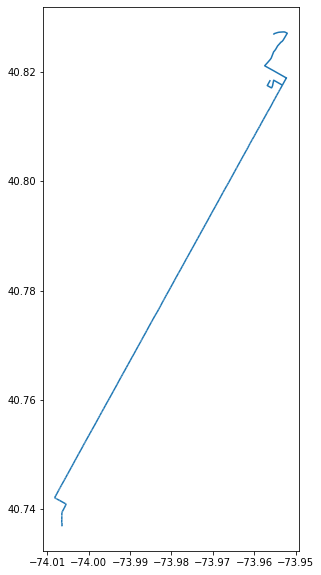

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

m11_route_gdf.plot(ax=ax)

plt.show()

In [ ]:
m11_geom = m11_gdf.iloc[0].geometry

In [ ]:
list(m11_geom.geoms)